# Supplementary Material: compute a PGS for yeast 8.5.0

yeast 8.5.0 is a more complex, more complete, model of yeast metabolism, which in turn leads to a notably larger computational load.

In [1]:
import cobra
import numpy as np
import pickle as pk
from tqdm import tqdm
from datetime import datetime
from multiprocessing import Pool
from matplotlib import pyplot as plt
from QuantitativeMutation import QuantitativeMutation

MODEL_NAME  = 'yeast_yeast8.5.0'
SOLVER_NAME = 'glpk'

# First load the model as a separate object
model = cobra.io.load_json_model('./metabolic_models/%s.json' % MODEL_NAME)

BIOMASS_ID = [rxn.id for rxn in model.reactions if 'growth' == rxn.name.lower() ][0]
ATPM_ID    = [rxn.id for rxn in model.reactions if 'maintenance' in rxn.name.lower() ]


#Define minimal medium...
minimal_medium = {}        
minimal_medium.update( {'r_1992'  :     2 }) #... oxygen
minimal_medium.update( {'r_2100'  : 9999 }) #... water
#minimal_medium.update( {'EX_co2_e': 9999 }) #... carbon dioxyde
minimal_medium.update( {'r_1654'  : 9999 }) #... ammonia
minimal_medium.update( {'r_2005'  : 9999 }) #... phosphate
minimal_medium.update( {'r_2060'  : 9999 }) #... sulphate
minimal_medium.update( {'r_2020'  : 9999 }) #... potassium
minimal_medium.update( {'r_2049'  : 9999 }) #... sodium
#... additional elements for yeast8
minimal_medium.update( {'r_1832'  : 9999 }) #... H+ exchange
minimal_medium.update( {'r_4593'  : 9999 }) #... chloride
minimal_medium.update( {'r_4594'  : 9999 }) #... Cu2(+)
minimal_medium.update( {'r_4595'  : 9999 }) #... Mn(2+)
minimal_medium.update( {'r_4596'  : 9999 }) #... Zn(2+)
minimal_medium.update( {'r_4597'  : 9999 }) #... Mg(2+)
minimal_medium.update( {'r_4600'  : 9999 }) #... Ca(2+)
minimal_medium.update( {'r_1861'  : 9999 }) #... Fe(2+)


#... and standard medium
std_medium = minimal_medium.copy()
std_medium.update( {  'r_1714' : 20 } ) #... D-glucose


# Load specific metabolic model...
Q = QuantitativeMutation( './metabolic_models/%s.json' % MODEL_NAME , 
                         biomass_id    = BIOMASS_ID,
                         system_rxn_id = ATPM_ID,
                         verbose=True)

#... set solver
Q.model.solver = SOLVER_NAME



#... and standard medium
Q.model.medium = std_medium



#Compute WT solution
wt_solution  = Q.optimize()
wt_growthrate= Q.slim_optimize()
print('Wild-type growth rate %1.3f' % Q.slim_optimize() )
print('')
print(datetime.now())


Academic license - for non-commercial use only - expires 2022-08-06
Using license file /home/pyubero/gurobi.lic
Loaded model M_yeastGEM_v8__46__5__46__0 from user file.
Biomass reaction id is r_2111
The model has 1150 genes and 4058 reactions.
... number of exchange reactions:	258
... number of non-exchange reactions:	3798
Wild-type growth rate 0.439

2022-05-15 12:31:06.128237


## 1. Compute maximal bounds of the fluxes under random media.

### Create or load a list of media that support growth rates $\mu \leq\mu_{WT}^{std}$


In [2]:
GENERATE_MEDIA_LIST = False   # set to False if a file with media already exists, or True otherwise
#...
RICHNESS    = 0.05            #... scale of the exponential distribution as described in the reference
                              # with richness 0.10 efficiency was ~0.01
                              # with richness 0.05 efficiency was ~0.22
MEDIA_LIST  = [std_medium,]   #... initialize the list containing the standard media
SAMPLES     = 10_000          #... number of random environments that you wish to compute
BATCH_SIZE  = 200             #... environments are computed in batches of BATCH_SIZE
MIN_GR      = 0.01            #... minimum growth rate to consider a model viable
MAX_GR      = wt_growthrate   #... maximum growth rate of valid media
_total      = 0               #... _total monitors the total number of media tested


#...
FILENAME    = 'Data_S_yeast8_random_media_list_%1.2f.pkl' % RICHNESS

import warnings
warnings.filterwarnings('ignore')


# This parallel function generates a random medium and returns whether it is valid (suc=True)
def parallel_function(dummy):
    np.random.seed()

    # Generate random medium
    new_medium =  Q.random_medium( m=RICHNESS, minimal=minimal_medium, upper_lim = 20, method='linear' )

    # Set medium, and optimize wild type
    with Q.model:
        Q.set_medium( new_medium )
        suc = MIN_GR<Q.model.slim_optimize()<MAX_GR

    # Return suc=True if the medium supports a growth >min_gr and <max_gr
    return suc, new_medium

    

    
if GENERATE_MEDIA_LIST:
    
    # Open Pool and initialize progress bar
    with Pool( processes=50) as p, tqdm(total=SAMPLES) as pbar:

        # For any number of batches necessary
        while len(MEDIA_LIST)<SAMPLES:

            # Run a batch...
            it = p.imap_unordered( parallel_function, range(BATCH_SIZE) )

            #... parse the batch and store the medium when suc == True
            for results in it:
                _total += 1

                if results[0]:
                    MEDIA_LIST.append( results[1] )
                    pbar.update(1)
                    if len(MEDIA_LIST)==SAMPLES:
                        break
            # Export media list
            with open(FILENAME, '+wb') as handle:
                pk.dump( MEDIA_LIST, handle)

        
    # Finished computing media list
    print('Efficiency: %1.4f' % ( len(MEDIA_LIST)/_total ) )
    print('Random media list with %d media exported! ' % len(MEDIA_LIST), datetime.now())

#...
else:
    
    # Load media list
    with open(FILENAME, 'rb') as handle:
        MEDIA_LIST = pk.load(handle)
        
    print('Loaded random media list with %d entries. ' % len(MEDIA_LIST), datetime.now() )
        

Loaded random media list with 10000 entries.  2022-05-15 12:31:06.729162


## Compute solutions, and with that, the "reference" bounds

In [3]:
LOAD_BOUNDS  = True             #... if you wish to load instead of calculate everything
EXPORT_DATA  = False            #... if you want to export the maximal bounds to a csv file
RICHNESS     = 0.05
SAMPLES      = len(MEDIA_LIST)  #... this should remain unchanged to len(MEDIA_LIST)
FILENAME_BOUNDS = 'Data_S_yeast8_bounds_%1.2f.csv' % RICHNESS

# Reset bounds
#Q.reset_bounds()


if LOAD_BOUNDS:
    Q.load_bounds(FILENAME_BOUNDS)    
    
    
if not LOAD_BOUNDS:
    # Compute bounds
    print('\nComputing bounds.')
    Q.compute_bounds(
                 media_list  = MEDIA_LIST, 
                 pfba        = False, 
                 kd_frac     = 0.0,
                 nprocessors = 50, 
                 chunksize   = 5)
    

    if EXPORT_DATA:
        Q.save_bounds(FILENAME_BOUNDS, description='nsamples=%d.' % SAMPLES)

Maxbounds loaded from Data_S_yeast8_bounds_0.05.csv on 2022-05-15 12:31:06.994991.


## 3a. Generate population of yeast metabolisms growing in the standard medium and...


In [4]:
import warnings
warnings.filterwarnings('ignore')


DISTRIBUTION = 'normal'      #... str : 'normal' (default)
SIGMA        = [1, 0.10 ]    #... list : [Gmean, Gstd_dev] if 'normal'
SAMPLES      = 20_000        #... int : 10_000, number of individuals in the populations
LOAD_DATA    = True
EXPORT_DATA  = False         #... bool : True, if you would like to export the results to a pkl file
FILENAME     = 'Data_S_yeast8_default_standard_population.npz'

Q.model.solver='gurobi'

if LOAD_DATA:
    data = np.load( FILENAME )
    G_std = data['G_std'] #... genotypes
    J_std = data['J_std'] #... fluxes
    f_std = data['f_std'] #... growth_rate

    f, G, J = Q.clear_population(f_std, [G_std,J_std], minimal_gr=1e-2)

    SAMPLES = G.shape[0]
    print('\nData loaded ' , datetime.now() )
    print('Number of samples loaded: %d' % SAMPLES)
    print('Number of total reactions: %d'%  Q.N_NEX_RXNS )
    print('Number of genes: %d' % Q.N_GENES )
    print('Mean growth rate: %1.3f +/- %1.3f' % (np.mean(f), np.std(f) ) )
    
else:
    # Create genotypes matrix
    G_std = np.array([ Q.random_genotype( sigma=SIGMA , method=DISTRIBUTION) for _ in range(SAMPLES) ] )

    # Create media list
    media = [ std_medium for _ in range(SAMPLES) ]

    # Compute population
    Q.load_bounds(FILENAME_BOUNDS)
    Q.reset_dosage()
    Q.apply_dosage()
    
    #### This was necessary because yeast8 and gurobi are not particularly stable ###
    f_std  = np.nan*np.zeros((SAMPLES,))
    J_std  = np.nan*np.zeros((SAMPLES,Q.N_NEX_RXNS))
    Ri_std = np.nan*np.zeros((SAMPLES,))

    new_feasible=1
    while new_feasible>0:
        _left    = np.isnan(Ri_std)
        idx_left = np.argwhere(_left)[:,0]
        n_left   = np.sum(idx_left)

        G_ = G_std[idx_left,:]
        med_= [std_medium for _ in range(len(idx_left) ) ]

        f_,_, J_,_, Ri_ = Q.compute_population( G_, med_ , nprocessors=50, chunksize=1)
        new_idx = np.argwhere((Ri_>0) & (f_>0))[:,0]
        f_std[ idx_left[new_idx] ]   = f_[new_idx]
        J_std[ idx_left[new_idx],: ] = J_[new_idx,:]
        Ri_std[ idx_left[new_idx] ]  = Ri_[new_idx]

        new_feasible=len(new_idx)
    

    # Check if there were inviable cases
    f,_ = Q.clear_population(f_std,[G_std,], minimal_gr=1e-2)
    
    print('Number of infeasible cases in mu %d' % np.sum(np.isnan(f_std)) )
    print('Number of infeasible cases in Ri %d' % np.sum(np.isnan(Ri_std)) )
    print('Ri = %1.5f +/- %1.5f' % (np.nanmean(Ri_std) ,np.nanstd(Ri_std) ) )
    print('mu = %1.5f +/- %1.5f' % (np.nanmean(f_std), np.nanstd(f_std) ) )

    # Export if necessary
    if EXPORT_DATA:
        np.savez( FILENAME , G_std=G_std, f_std=f_std, J_std=J_std, media=media, Ri_std = Ri_std )
        print('Data exported to %s on %s' % (FILENAME, datetime.now() ))

    




 <W> Clearing 0 individuals from the population

Data loaded  2022-05-15 12:31:20.020292
Number of samples loaded: 20000
Number of total reactions: 3798
Number of genes: 1150
Mean growth rate: 0.331 +/- 0.019


## 4. Compute Phenotypic Prediction Score by OLS and by LASSO and...

In [5]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

LOAD_PPS  = True
EXPORT_PPS= False                       #...
NTRAIN    = np.min((5_000, SAMPLES))    #... int 5000; training population size
FILENAME_PPS = 'Data_S_yeast8_PPS_def_std.npz'

if LOAD_PPS:
    data = np.load(FILENAME_PPS)
    coef_std = data['B_std']  #... Effect size
    R2_std  = data['R2_std'] #... PPS R2

    SAMPLES = G_std.shape[0]

    print('Data laoded.')
    print('# samples:\t%d' % SAMPLES )
    print('R2 of PPS: \t%1.4f' % R2_std )

    
else:
    # Prepare population before fitting,
    #... i.e. subtract the mean, but store it.
    f,G, J = Q.clear_population(f_std,[G_std,J_std], minimal_gr=1e-2)
    
    train_idx = np.arange(0, NTRAIN )

    X0= np.nanmean( G[train_idx,:], axis = 0 )
    y0= np.nanmean( f[train_idx] )

    X = G[train_idx,:] - X0
    y = f[train_idx]   - y0


    print('Training set size %d' % X.shape[0])
    print('Number of predictors %d' % X.shape[1])


    ####################################
    #========= OLS REGRESSION =========#
    ols = LinearRegression(fit_intercept = False, normalize = False, positive=False).fit(X , y)
    ols_ypred = ols.predict(X)

    ols_coef  = ols.coef_
    ols_R2    = r2_score(y, ols_ypred)
    ols_rmse  = mean_squared_error(y, ols_ypred, squared=False)

    print('')
    print('#========= OLS REGRESSION =========#')
    print('R2 = %1.4f' % ols_R2 )
    print('Non-null predictors %d' % np.sum( ols_coef != 0 ) )
    print('RMSE = %1.4f' % ols_rmse)


    ####################################
    #======== LASSO REGRESSION ========#
    lasso = LassoCV(fit_intercept = False , positive= False ).fit(X, y)
    lasso_ypred = lasso.predict(X)

    lasso_coef  = lasso.coef_
    lasso_R2    = r2_score(y, lasso_ypred)
    lasso_rmse  = mean_squared_error(y, lasso_ypred, squared=False)
    lasso_alpha = lasso.alpha_

    print('')
    print('#======== LASSO REGRESSION ========#')
    print('R2 = %1.4f' % lasso_R2 )
    print('Non-null predictors %d' % np.sum( lasso_coef != 0 ) )
    print('RMSE = %1.4f' % lasso_rmse)
    print('Optimal alpha is %1.3e' % lasso_alpha)


    if EXPORT_PPS:
        exportable_data = {}
        #...
        exportable_data.update( {'G_std' : G[train_idx,:] } ) #... genotype matrix
        exportable_data.update( {'f_std' : f[train_idx] } )   #... true fitness values from FBA
        exportable_data.update( {'J_std' : J[train_idx,:] } ) #... fluxes of all solutions
        #... 
        exportable_data.update( {'B_std' : lasso_coef } ) #... effect sizes
        exportable_data.update( {'R2_std': lasso_R2 } )   #... R2


        np.savez(FILENAME_PPS, **exportable_data)
        print('')
        print('Data exported! ', datetime.now() )

Data laoded.
# samples:	20000
R2 of PPS: 	0.1733


### [plot] Summary

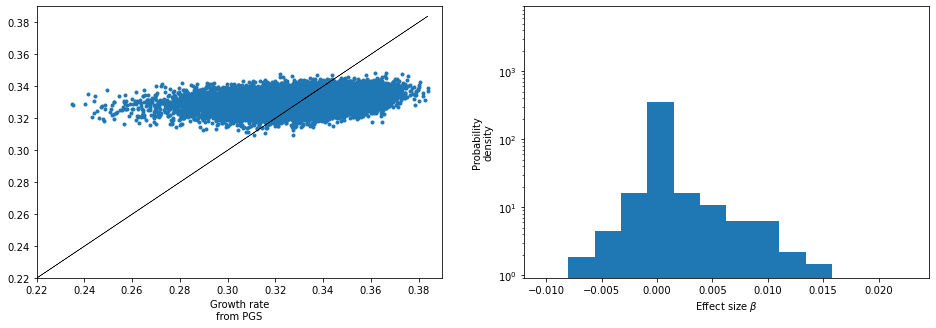

In [6]:
xx = np.linspace( np.min(coef_std), np.max(coef_std), 15)
y_pred = np.matmul(G_std-np.nanmean(G_std, axis=0), coef_std)+np.nanmean(f_std)


plt.figure( figsize=(16,5) )
plt.subplot(1,2,1)
plt.plot(f_std, y_pred,'.')
plt.plot(f_std,f_std, 'k', lw=0.5)
plt.xlim(0.22, 0.39)
plt.ylim(0.22, 0.39)
plt.xlabel('Growth rate\nfrom FBA')
plt.xlabel('Growth rate\nfrom PGS')

plt.subplot(1,2,2)
plt.hist(coef_std, bins=xx, density=True)
plt.yscale('log')
plt.xlabel(r'Effect size $\beta$')
plt.ylabel('Probability\ndensity')
plt.yscale('log')
plt.ylim(0.9,9000)
plt.yticks( ticks=(1,10,100,1000));